In [112]:
# 데이터 불러오기
import pandas as pd
from pykrx import stock
import FinanceDataReader as fdr
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import seaborn as sns
import warnings
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [145]:
# 결측치는 금융 기업 데이터라서 삭제
log_df = pd.read_csv('data/제조업_수익률.csv', dtype = {'주식코드':str}).dropna()

In [133]:
# (원)단위 컬럼 제거
col_list = []
for col in log_df.columns:
    if '원)' in col:
        col_list.append(col)
print(col_list)
log_df.drop(columns=col_list,inplace=True)

['1주당매출액(IFRS)(원)', '1주당순이익(IFRS)(원)', '1주당 CASH FLOW(IFRS)(원)', '1주당순자산(IFRS)(원)', '1주당정상영업이익(IFRS)(원)', '부가가치(IFRS)(백만원)', '종업원1인당 부가가치(IFRS)(백만원)', '종업원1인당 매출액(IFRS)(백만원)', '종업원1인당 정상영업이익(IFRS)(백만원)', '종업원1인당 순이익(IFRS)(백만원)', '종업원1인당 인건비(IFRS)(백만원)']


In [134]:
log_df

,총자본증가율(IFRS),유형자산증가율(IFRS),비유동생물자산증가율(IFRS),투자부동산증가율(IFRS),비유동자산증가율(IFRS),유동자산증가율(IFRS),재고자산증가율(IFRS),자기자본증가율(IFRS),매출액증가율(IFRS),정상영업이익증가율(IFRS),...,기계장비율(IFRS),자본집약도(IFRS),총자본투자효율(IFRS),설비투자효율(IFRS),기계투자효율(IFRS),부가가치율(IFRS),노동소득분배율(IFRS),자본분배율(IFRS),이윤분배율(IFRS),수익율
0,-1.22,-4.16,0.0,-1.29,-1.31,0.11,8.61,3.10,19.75,20.36,...,46.29,2047.99,8.57,41.80,379.17,35.08,19.66,80.34,20.01,0.500000
2,-3.07,-7.75,0.0,-1.26,-2.50,-11.26,-33.22,3.00,-8.21,-7.44,...,0.00,0.00,9.12,47.66,647.91,37.96,18.25,81.75,23.48,-0.016835
3,2.29,-6.58,0.0,-1.13,0.96,23.35,58.28,2.56,-3.13,-1.11,...,0.00,0.00,7.22,41.34,1552.83,31.75,19.89,80.11,32.96,0.320000
4,5.68,-69.74,0.0,5.71,-5.79,153.86,-60.76,1.58,-9.15,-0.01,...,0.00,0.00,6.22,134.74,18933.42,31.82,15.85,84.15,27.55,0.130653
5,-6.47,-36.42,0.0,-4.87,6.78,-69.95,-67.10,2.53,-10.84,-34.89,...,0.00,0.00,5.85,171.96,29079.87,31.37,10.08,89.92,36.68,-0.249057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2670,9.19,297.21,0.0,0.00,36.05,-34.33,-11.57,17.77,-10.37,-23.65,...,0.00,0.00,28.54,140.78,0.00,36.16,11.37,88.63,58.94,-0.056980
2671,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,6.34,2127.64,80447.21,80.42,9.21,90.79,91.10,0.214118
2672,-1.77,-1.78,0.0,0.00,-5.59,111.96,0.00,-7.60,-69.96,-81.79,...,5.57,77491.44,-2.38,-694.84,-33101.32,-98.60,0.00,0.00,0.00,-0.434840
2673,-3.32,-28.67,0.0,0.00,-11.28,102.38,0.00,-4.23,-0.07,19.71,...,0.00,0.00,-3.75,-1488.60,-76262.86,-150.41,0.00,0.00,0.00,-0.147392


In [135]:
# 엑셀 컬럼 맞게 자율적으로 전처리하기 y값 떼기, 주식코드, 회사명등 처리
X = log_df.drop(['수익율'],axis=1)
y = log_df['수익율']

In [136]:
# 상관관계가 0.5보다 낮은 값들만 구성된 컬럼은 제거
corr = X.corr()

In [137]:
# 각 컬럼별로, 자기 자신을 제외한 나머지 컬럼들과의 상관계수 절대값이 모두 0.5 미만인지 확인
cols_to_drop = []
for col in corr.columns:
    # 자기 자신 제외 (상관계수 1)
    other_corrs = corr[col].drop(col)
    if all(other_corrs.abs() < 0.5):
        cols_to_drop.append(col)

In [138]:
# 해당 컬럼 삭제
filtered_X = X.drop(columns=cols_to_drop)

In [139]:
def parallel_analysis_scree_plot(data, n_iter=100, random_state=None):
    """
    평행 분석과 스크리 도표를 결합한 시각화 함수
    """
    # 데이터 표준화
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # 실제 데이터 요인 분석
    fa = FactorAnalyzer(rotation='varimax', use_smc=True, method = 'principal')
    fa.fit(data_scaled)
    real_eigenvalues, _ = fa.get_eigenvalues()

    # 무작위 데이터 생성 및 분석
    n_samples, n_features = data.shape
    random_eigenvalues = np.zeros((n_iter, n_features))

    np.random.seed(random_state)
    for i in range(n_iter):
        random_data = np.random.normal(size=(n_samples, n_features))
        fa.fit(random_data)
        rand_eig, _ = fa.get_eigenvalues()
        random_eigenvalues[i] = rand_eig

    # 평균 및 95th 백분위수 계산
    mean_random_eigen = np.mean(random_eigenvalues, axis=0)
    percentile_95 = np.percentile(random_eigenvalues, 95, axis=0)

    # 시각화 설정
    plt.figure(figsize=(10, 6))
    components = range(1, n_features+1)

    # 실제 데이터 스크리 플롯
    plt.plot(components, real_eigenvalues, 'bo-',
             linewidth=2, label='Actual Data')

    # 무작위 데이터 평균/95th
    plt.plot(components, mean_random_eigen, 'r--',
             linewidth=2, label='Random Mean')
    plt.plot(components, percentile_95, 'g-.',
             linewidth=2, label='95th Percentile')

    # 카이저 기준선
    plt.axhline(y=1, color='k', linestyle='--', label='Kaiser Criterion')

    # 교차점 강조
    optimal_factors = np.where(real_eigenvalues > percentile_95)[0]
    if len(optimal_factors) > 0:
        plt.scatter(optimal_factors+1, real_eigenvalues[optimal_factors],
                    s=200, facecolors='none', edgecolors='m',
                    label='Optimal Factors')

    plt.title('Parallel Analysis Scree Plot')
    plt.xlabel('Factor Number')
    plt.ylabel('Eigenvalue')
    plt.xticks(components)
    plt.legend()
    plt.grid(True)
    plt.show()

    # 최적 요인 수 제안
    suggested_factors = len(optimal_factors)
    print(f'Suggested number of factors: {suggested_factors}')
    return suggested_factors

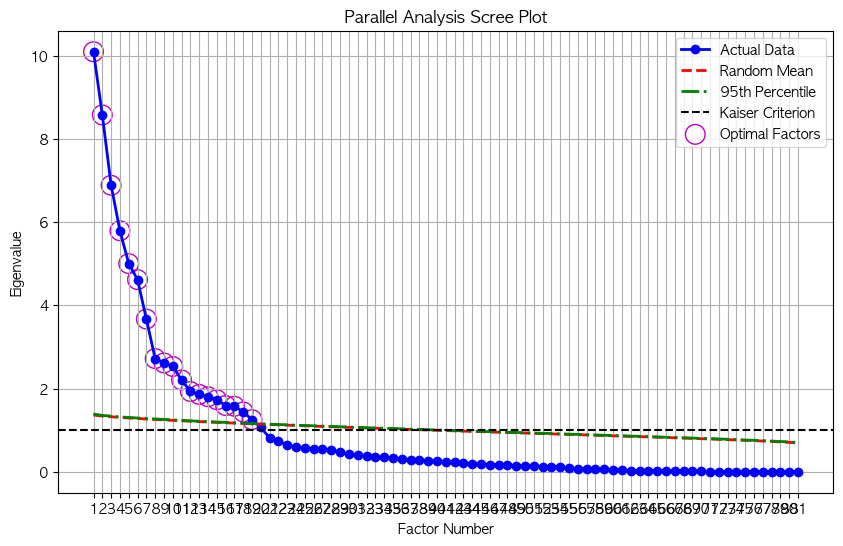

Suggested number of factors: 19


In [140]:
# 최적의 요인 개수 찾기
optim = parallel_analysis_scree_plot(filtered_X, n_iter=100, random_state=42)

In [141]:
# 데이터 스케일링
scaler = StandardScaler()
scaled_data = scaler.fit_transform(filtered_X)

In [142]:
def make_factor_score_df(n, data):
    fa = FactorAnalyzer(n_factors=n, method='principal', rotation='varimax')
    fit = fa.fit(data)
    loading = fit.loadings_.T
    # masked_loadings = np.where(np.abs(loading) >= 0.6, loading, 0)
    factor_scores = data.values @ loading.T # data 전체 사용
    df = pd.DataFrame(factor_scores, columns=[f"factor_{i+1}" for i in range(n)])
    return df

In [143]:
X = make_factor_score_df(optim, filtered_X)
X.to_excel("factor.xlsx",index=False)

In [ ]:
X = X.reset_index(drop=True)
y_reset = y.reset_index(drop=True)

# 회귀분석 진행
model = sm.OLS(y_reset,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    수익율   R-squared (uncentered):                   0.037
Model:                            OLS   Adj. R-squared (uncentered):              0.030
Method:                 Least Squares   F-statistic:                              5.225
Date:                Wed, 21 May 2025   Prob (F-statistic):                    1.37e-12
Time:                        15:58:58   Log-Likelihood:                         -1421.7
No. Observations:                2601   AIC:                                      2881.
Df Residuals:                    2582   BIC:                                      2993.
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
factor_1    2.407e-05    2.2e-05      1.092      0.275   -1.91e-05    6.73e-05
factor_2   -1.213e-05   1.01e-05     -1.196      0.232    -3.2e-05    7.75e-06
factor_3   -6.398e-05   5.97e-05     -1.071      0.284      -0.000    5.31e-05
factor_4   -1.209e-05   8.13e-06     -1.487      0.137    -2.8e-05    3.85e-06
factor_5     1.13e-05   8.75e-06      1.291      0.197   -5.86e-06    2.85e-05
factor_6   -3.381e-05   3.06e-05     -1.103      0.270   -9.39e-05    2.63e-05
factor_7    2.651e-05   3.07e-05      0.862      0.389   -3.38e-05    8.68e-05
factor_8      -0.0002   6.96e-05     -3.490      0.000      -0.000      -0.000
factor_9       0.0001   4.84e-05      2.210      0.027    1.21e-05       0.000
factor_10   6.578e-06   8.65e-06      0.760      0.447   -1.04e-05    2.35e-05
factor_11  -1.777e-05   6.95e-06     -2.557      0.011   -3.14e-05   -4.14e-06
factor_12  -5.963e-05      0.000     -0.422      0.673      -0.000       0.000
factor_13   1.111e-06   6.05e-06      0.184      0.854   -1.08e-05     1.3e-05
factor_14  -3.637e-06   1.61e-05     -0.226      0.821   -3.52e-05    2.79e-05
factor_15   1.426e-06   3.14e-06      0.455      0.649   -4.72e-06    7.58e-06
factor_16   5.667e-06   6.63e-06      0.855      0.393   -7.33e-06    1.87e-05
factor_17   1.799e-05   1.82e-05      0.987      0.324   -1.78e-05    5.37e-05
factor_18      0.0001    4.4e-05      2.647      0.008    3.02e-05       0.000
factor_19   2.376e-05   3.48e-05      0.683      0.494   -4.44e-05    9.19e-05
==============================================================================
Omnibus:                      424.464   Durbin-Watson:                   2.179
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1373.585
Skew:                           0.817   Prob(JB):                    5.37e-299
Kurtosis:                       6.163   Cond. No.                     8.92e+06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 8.92e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""